In [7]:
from IPython.display import HTML
import pandas as pd
import urllib2
from bs4 import BeautifulSoup

# Data
###craigslist has ~300 rental listings in SD (better sources?)
school's apartment resources:
+ http://offcampushousing.ucsd.edu/media/apartmentmap08_front.pdf
+ http://offcampushousing.ucsd.edu/media/apartmentmap08_back.pdf

In [37]:
# relevant listings
CL_SD_apartment_rent_search_urls = ['https://sandiego.craigslist.org/search/apa?is_paid=all&search_distance_type=mi&query=ucsd',
                                    'https://sandiego.craigslist.org/search/apa?s=100&is_paid=all&query=ucsd&search_distance_type=mi',
                                    'https://sandiego.craigslist.org/search/apa?s=200&is_paid=all&query=ucsd&search_distance_type=mi',
                                    'https://sandiego.craigslist.org/search/apa?s=300&is_paid=all&query=ucsd&search_distance_type=mi']

In [610]:
# start scraping webdata
price_and_bedroom_and_location_span_tags = []
date_and_title_span_tags = []
listing_url_tags = []

for CL_SD_apartment_rent_search_url in CL_SD_apartment_rent_search_urls:
    response = urllib2.urlopen(CL_SD_apartment_rent_search_url)
    soup = BeautifulSoup(response.read(), 'html.parser')
    price_and_bedroom_and_location_span_tags += soup.find_all("span", class_="l2")
    date_and_title_span_tags += soup.find_all("span", class_="pl")
    listing_url_tags += soup.find_all("a", class_="hdrlnk")

In [621]:
# wrangle webdata into csv formatted dataset
DATASET_NAME = 'cl_sd_apa_rentals.csv'

import re
price_regex_pattern   = re.compile("\$(\d+)")
bedroom_regex_pattern = re.compile("\dbr")
location_regex_pattern= re.compile("\(.*\)")

HEADER = '\t'.join(['price', 'n_bedrooms', 'place', 'url', 'address', 'title', 'date'])
lines = [HEADER]

N = len(price_and_bedroom_and_location_span_tags)

for i in range(N):
    p_and_b_and_l_tag = price_and_bedroom_and_location_span_tags[i]
    price_node = p_and_b_and_l_tag.find("span", class_="price")
    bedroom_node = p_and_b_and_l_tag.find("span", class_="housing")
    location_node = p_and_b_and_l_tag.find("small")

    date_and_title_span_tag = date_and_title_span_tags[i]
    date_node = date_and_title_span_tag.find("time")
    title_node = date_and_title_span_tag.find("a")

    price = ''
    n_bedrooms = ''
    place = ''
    url = ''
    address = ''
    title = ''
    date = ''

    if price_node:
        r = price_regex_pattern.search(price_node.getText())

        if r:
            price = r.group(0)

    if bedroom_node:
        r = bedroom_regex_pattern.search(bedroom_node.getText())

        if r:
            n_bedrooms = r.group(0)

    if location_node:
        r = location_regex_pattern.search(location_node.getText())

        if r:
            place = r.group(0)
            place = place.strip('()')

    if title_node:
        title = title_node.getText().encode("utf8")

    if date_node:
        date = date_node['title']

    if listing_url_tags[i]['href']:
        url = 'https://sandiego.craigslist.org/' + listing_url_tags[i]['href']

        response = urllib2.urlopen(url)
        soup = BeautifulSoup(response.read(), 'html.parser')
        mapaddress_tag = soup.find_all('div', class_='mapaddress')

        if mapaddress_tag:
            address = mapaddress_tag[0].getText()

    row = [s.decode('utf-8') for s in [price, n_bedrooms, place, url, address, title, date]]
    lines += ['\t'.join(row)]
    
with open(DATASET_NAME+'a', 'w') as csvfile:
    for line in lines:
        print>>csvfile, line.encode('utf-8')#.replace(u'\xbd','')

In [620]:
df = pd.read_csv(DATASET_NAME, delimiter='\t')
df.head(10)

,price,n_bedrooms,place,url,address,title,date
0,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54358...,3520 Lebon Dr.,"Furnished, quiet, close to UCSD, Scripps, beac...",Mon 22 Feb 08:41:27 AM
1,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54508...,3520 Lebon Dr.,"Furnished, quiet, close to UCSD, Scripps, beac...",Mon 22 Feb 12:07:58 AM
2,$4600,6br,"San Diego,Clairmont, UCSD, Unv. City",https://sandiego.craigslist.org//csd/apa/54526...,NaN,Close to UCSD!4bed/ huge loft/1 sm room2 bath ...,Sun 21 Feb 02:27:51 PM
3,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54500...,3520 Lebon Dr.,"Furnished, quiet, close to UCSD, Scripps, beac...",Sun 21 Feb 10:42:45 AM
4,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54219...,3520 Lebon Dr.,"Furnished, quiet, close to UCSD, Scripps, beac...",Sat 20 Feb 09:51:46 AM
5,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54520...,3520 Lebon Dr.,"Furnished, quiet, close to UCSD, Scripps, beac...",Fri 19 Feb 03:21:07 PM
6,$1599,1br,UCSD / UTC / La Jolla,https://sandiego.craigslist.org//csd/apa/54342...,nobel at lebon,"Furnished apartment available April 1, near UC...",Fri 19 Feb 10:12:15 AM
7,$2250,1br,UTC/ UCSD,https://sandiego.craigslist.org//csd/apa/54460...,3440 Lebon Dr.,Cool Ocean Breezes! Luxury 1BR Condo near UCSD...,Fri 19 Feb 03:59:19 AM
8,$3400,3br,La Jolla/UCSD,https://sandiego.craigslist.org//csd/apa/54509...,8274 Caminito Sonoma,La Jolla/UCSD Townhouse for Rent,Tue 16 Feb 01:39:14 PM
9,$2700,3br,UCSD-UTC,https://sandiego.craigslist.org//csd/apa/54509...,caminito modena at caminito sonoma,UCSD-UTC,Tue 16 Feb 01:33:56 PM


##Estimating Distance with MapsApi
tutorial https://developers.google.com/maps/documentation/distance-matrix/intro
####(Assume transit mode is bus)
create unique api key credentials https://developers.google.com/maps/documentation/distance-matrix/get-api-key

In [171]:
API_KEY_FILENAME = 'mapsapikeyfile'
api_key = ''

with open (API_KEY_FILENAME, "r") as myfile:
    first_line = myfile.readlines()[0]
    api_key = first_line.strip()

In [623]:
is_missing_address = df.address.apply(pd.isnull)
our_dataset_with_full_addresses_only = df[~is_missing_address]

In [624]:
from requests.compat import quote_plus
import json

distances_in_miles = []
times_in_minutes = []

SCHOOL_ADDRESS = '9500 Gilman Dr, La Jolla CA'
MAX_ELEMENTS_QUERYABLE_PER_REQUEST = 100

rental_addresses = our_dataset_with_full_addresses_only.address

def fix_rental_addresses_strings(rental_addresses):
    rental_addresses = rental_addresses.apply(lambda a : quote_plus(a[:a.index('at')] + ', San Diego' if 'at' in a else a))
    rental_addresses = map(lambda a : quote_plus(SCHOOL_ADDRESS) if len(a) <= 5 else a, rental_addresses)
    return rental_addresses

rental_addresses = fix_rental_addresses_strings(rental_addresses)
rental_addresses_encoded_as_get_parameters = '|'.join(rental_addresses)

parameters = {'transit_mode': 'bus',
             'destinations': quote_plus(SCHOOL_ADDRESS),
             'key': api_key,
             'units': 'imperial'}

maps_api_base_url = "https://maps.googleapis.com/maps/api/distancematrix/json?"
origin_addresses_chunk_size = MAX_ELEMENTS_QUERYABLE_PER_REQUEST/2

for i in range(0, len(rental_addresses), origin_addresses_chunk_size):
    parameters['origins'] = '|'.join(rental_addresses_encoded_as_get_parameters.split('|')[i:i+origin_addresses_chunk_size])
    query = maps_api_base_url + '&'.join(['{key}={val}'.format(key=k, val=v) for k,v in parameters.items()])
    #print query
    #print 
    response = urllib2.urlopen(query)
    time_distance_data = json.loads(response.read())
    
    def get_distance_or_duration(maps_api_result_row, distance_or_duration='distance'):
        if distance_or_duration in r['elements'][0]:
            return r['elements'][0][distance_or_duration]['text']
        else:
            return ''
    
    distances_in_miles += [get_distance_or_duration(r, 'distance') for r in time_distance_data['rows']]
    times_in_minutes += [get_distance_or_duration(r, 'duration') for r in time_distance_data['rows']]

In [625]:
our_dataset_with_full_addresses_only['distance'] = distances_in_miles
our_dataset_with_full_addresses_only['time'] = times_in_minutes

/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [4]:
our_dataset_with_full_addresses_only.to_csv(DATASET_NAME, sep='\t', index=False)
our_dataset_with_full_addresses_only = pd.read_csv(DATASET_NAME, sep='\t')
our_dataset_with_full_addresses_only.head()

,price,n_bedrooms,place,url,address,distance,time
0,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54500...,3520 Lebon Dr.,2.6 mi,8 mins
1,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54219...,3520 Lebon Dr.,2.6 mi,8 mins
2,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54520...,3520 Lebon Dr.,2.6 mi,8 mins
3,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54358...,3520 Lebon Dr.,2.6 mi,8 mins
4,$3400,3br,La Jolla/UCSD,https://sandiego.craigslist.org//csd/apa/54509...,8274 Caminito Sonoma,3.0 mi,8 mins


In [5]:
our_dataset_with_full_addresses_only['price'] = our_dataset_with_full_addresses_only.price.apply(lambda p : int(p[1:]))
our_dataset_with_full_addresses_only['distance'] = our_dataset_with_full_addresses_only.distance.apply(lambda d : float(d.split()[0].replace(',', '') if isinstance(d, basestring) else 0))
our_dataset_with_full_addresses_only['time'] = our_dataset_with_full_addresses_only.time.apply(lambda t : int(t.split()[0] if isinstance(t, basestring) else 0))
our_dataset_with_full_addresses_only['n_bedrooms'] = our_dataset_with_full_addresses_only.n_bedrooms.apply(lambda n_bedroom : int(n_bedroom.strip('br') if isinstance(n_bedroom, basestring) else 0))

In [628]:
our_dataset_with_full_addresses_only.describe()

,price,n_bedrooms,distance,time
count,274.000000,274.000000,274.000000,274.000000
mean,2034.766423,1.631387,112.179197,10.372263
std,694.100749,0.913413,487.301682,4.844100
min,195.000000,0.000000,0.000000,0.000000
25%,1627.500000,1.000000,2.600000,8.000000
50%,1877.500000,1.000000,3.500000,10.000000
75%,2328.750000,2.000000,4.950000,12.000000
max,6000.000000,5.000000,3121.000000,28.000000


##Estimating Cost by Metric
###PPBI: price per bedroom index
(methodology utilized by Trulia maps)

In [8]:
trulia_article = "http://sf.curbed.com/archives/2013/09/16/trulias_interactive_map_of_rental_prices_shows_san_francisco_as_one_big_redzone.php"
HTML("<iframe src='{0}' height=500 width=700></iframe>".format(trulia_article))

calculate ppbi

In [9]:
our_dataset_with_full_addresses_and_n_bedrooms_only = our_dataset_with_full_addresses_only[our_dataset_with_full_addresses_only.n_bedrooms > 0]
our_dataset_with_full_addresses_and_n_bedrooms_only['ppbi'] = our_dataset_with_full_addresses_and_n_bedrooms_only.price / our_dataset_with_full_addresses_and_n_bedrooms_only.n_bedrooms

/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline
sns.set_style("whitegrid")

sns.pairplot(our_dataset_with_full_addresses_and_n_bedrooms_only[['price', 'distance', 'time', 'ppbi', 'n_bedrooms']])
plt.show()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


let's remove outliers according to the (ppbi, distance) plot, say rentals outside of 50 mi.

In [12]:
df = our_dataset_with_full_addresses_and_n_bedrooms_only[our_dataset_with_full_addresses_and_n_bedrooms_only.distance < 50]

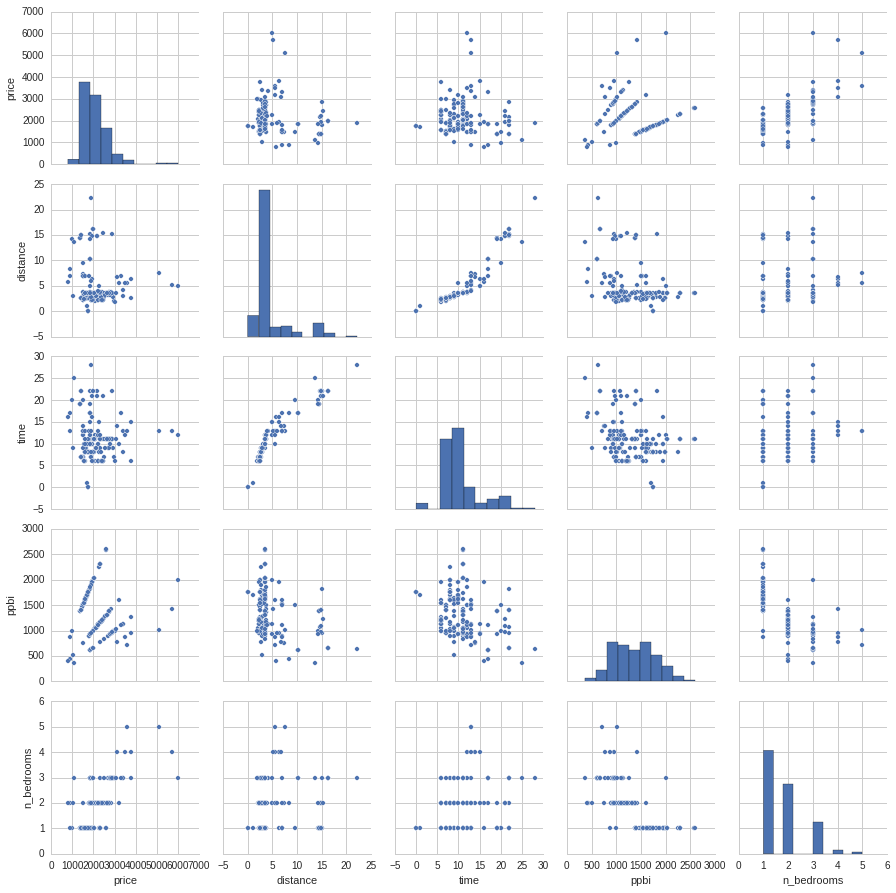

In [633]:
sns.pairplot(df[['price', 'distance', 'time', 'ppbi', 'n_bedrooms']])

time vs ppbi seems interesting..

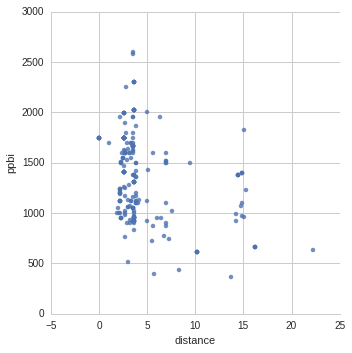

In [634]:
sns.lmplot("distance", "ppbi", data=df, fit_reg=False)

distance or time? interchangeable, with linear regression equation

In [635]:
import statsmodels.formula.api as sm

result = sm.ols(formula="time ~ distance- 1", data=df).fit()
print result.params
print result.summary()

distance    1.856044
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1912.
Date:                Mon, 22 Feb 2016   Prob (F-statistic):          2.79e-118
Time:                        14:26:53   Log-Likelihood:                -688.47
No. Observations:                 248   AIC:                             1379.
Df Residuals:                     247   BIC:                             1382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
distance       1

$$ \textrm{minutes on bus} = f(\textrm{miles from UCSD}) \simeq 2 \cdot \textrm{miles from UCSD}$$

OK, now let's use Kmeans to find groups in our dataset

use feature normalization on our design matrix
http://stats.stackexchange.com/a/70807

$$z_i = {{x_i - \textrm{min}(x)} \over {\textrm{max}(x) - \textrm{min}(x)}}$$

In [14]:
from sklearn.cluster import KMeans
import numpy as np

X = df[['distance', 'ppbi']].as_matrix()
X = np.array(X.tolist())

def normalize(vector):
    vector = ( np.array(vector) - min(vector) ) / max(vector) - min(vector)
    return vector

X_norm = X
X_norm[:,0] = normalize(X[:,0])# normalize distance/time
X_norm[:,1] = normalize(X[:,1])# normalize ppbi: price per bedroom index

K = 3
k_means = KMeans(n_clusters=K)
k_means.fit(X_norm)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [16]:
plt.style.use('fivethirtyeight')

# Compute clustering with Means
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

# Plot result
fig = plt.figure(figsize=(12,8))

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
colors = ['#4E9A06', '#FF9C34', '#4EACC5']

import matplotlib.pyplot as plt

# KMeans
for k, col in zip(range(K), colors):
    my_members = k_means_labels == k
    cluster_center = df.distance[my_members].mean(), df.ppbi[my_members].mean()#k_means_cluster_centers[k]
    plt.scatter(df.distance[my_members], df.ppbi[my_members], #'w',
            color=col, marker='o', s=18)
    plt.plot(cluster_center[0], cluster_center[1], 'ro', markerfacecolor='red',
            markeredgecolor='black', markersize=8)
    
plt.plot([0.3, 0.3], [2000,3000], '*-', c='r', lw=2, markerfacecolor='yellow', markersize=16)


plt.xlim((0, 25))
plt.ylim((0, 3400))

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

ax.set_xticklabels(['']+list(range(5,30,5)))
ax.set_xlabel("distance (miles)", labelpad=23)
ax.set_ylabel("price  (dollars/ month) ", labelpad=23)
ax.set_title("Price per Bedroom vs Distance from UC San Diego", y=1.08)
plt.figtext(.5,.93,'Cluster Analysis on Apartment Rentals Relative to Campus Cost',fontsize=14,ha='center')
ax.legend()
plt.show()

In [638]:
kmean_labels_map = {0: 'near-cheap', 1: 'near-expensive', 2: 'far-cheap'}
df['group'] = map(lambda lab : kmean_labels_map[lab], k_means_labels)

/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [ ]:
vcs = df.group.value_counts()
vcs

In [17]:
vcs/sum(vcs)

NameError: name 'vcs' is not defined

Analyze popular words

In [685]:
import string
near_cheap_words = ' '.join(df.title[df.group=='near-cheap'].tolist())
near_cheap_words = ''.join(map(lambda c : ' '+c+' ' if c in set(string.punctuation) else c, list(near_cheap_words)))

In [727]:
from collections import Counter
from operator import itemgetter

count = Counter(near_cheap_words.split())
keys_ranked_by_appearance = map(itemgetter(0), count.most_common())
near_cheap_words_count = pd.DataFrame(pd.Series(dict(count))).transpose()

NEAR_CHEAP_WORDS_TSV_FILENAME = 'near_cheap_words_count.tsv'
near_cheap_words_count[keys_ranked_by_appearance].transpose().to_csv(NEAR_CHEAP_WORDS_TSV_FILENAME, sep='\t')
near_cheap_words_count[keys_ranked_by_appearance]

,!,",",*,-,1st,2,/,Month,Bedroom,UCSD,...,Inviting,welcome,Drive,April,Gardens,Loft,3rd,home,PRICE,Executive
0,168,67,60,34,33,33,33,29,26,20,...,1,1,1,1,1,1,1,1,1,1


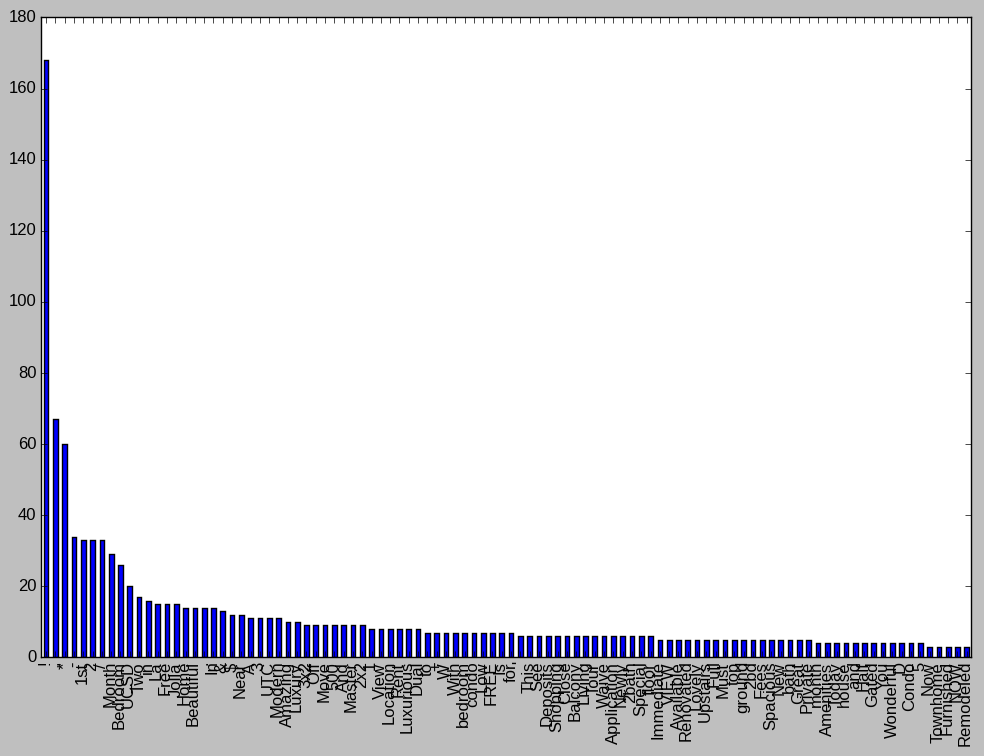

In [765]:
plt.rcdefaults()
near_cheap_words_count[keys_ranked_by_appearance[:100]].transpose().plot(kind='bar',
                                                                   figsize=(12,8),
                                                                   legend=False)